In [2]:
# import libraries 
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.font_manager import FontProperties 
import pingouin as pg
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

In [3]:
# define global figure properties 
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # display figures in vector format
plt.rcParams.update({'font.size':14,             # font size
                     'axes.titlelocation':'left',# title location
                     'axes.spines.right':False,  # remove axis bounding box
                     'axes.spines.top':False,    # remove axis bounding box
                     })

# Exe 1

In [4]:
# the raw data
elves  = np.array([17, 20, 16, 22, 20, 12, 15, 23,  9, 22, 21, 19, 12    ])
dwarfs = np.array([15, 14, 15, 25, 19, 16, 20, 18, 18, 15, 18, 13, 14, 15])
trolls = np.array([14, 16, 11, 17, 12, 13, 10, 12, 10, 18, 13, 14, 11, 20])

In [5]:
# descriptive statistics

# sample sizes
Nelves  = len(elves)
Ndwarfs = len(dwarfs)
Ntrolls = len(trolls)

# means
mean_elves  = np.mean(elves)
mean_dwarfs = np.mean(dwarfs)
mean_trolls = np.mean(trolls)

# standard errors
sem_elves  = np.std(elves, ddof=1) / np.sqrt(Nelves)
sem_dwarfs = np.std(dwarfs,ddof=1) / np.sqrt(Ndwarfs)
sem_trolls = np.std(trolls,ddof=1) / np.sqrt(Ntrolls)

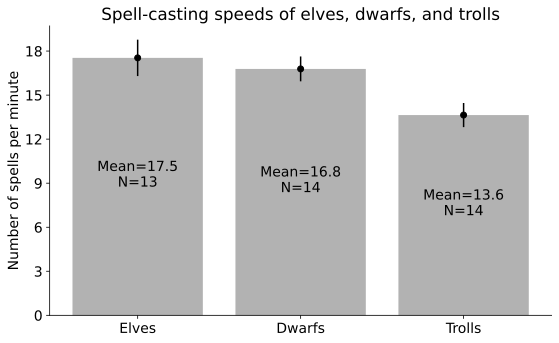

In [6]:
# error bar plot
plt.figure(figsize=(8,5))

# the bars
plt.bar(range(3),[mean_elves,mean_dwarfs,mean_trolls],color=(.7,.7,.7))
plt.errorbar(range(3),[mean_elves,mean_dwarfs,mean_trolls],
             yerr=[sem_elves,sem_dwarfs,sem_trolls],fmt='ko')

# text in bars
plt.text(0,mean_elves/2, f'Mean={mean_elves:.1f}\nN={Nelves}',ha='center')
plt.text(1,mean_dwarfs/2,f'Mean={mean_dwarfs:.1f}\nN={Ndwarfs}',ha='center')
plt.text(2,mean_trolls/2,f'Mean={mean_trolls:.1f}\nN={Ntrolls}',ha='center')

# ticks and labels
plt.xticks(range(3),['Elves', 'Dwarfs', 'Trolls'])
plt.yticks(np.arange(19,step=3))
plt.ylabel('Number of spells per minute')
plt.title('Spell-casting speeds of elves, dwarfs, and trolls',loc='center')

# display the figure
plt.tight_layout()
plt.show()

In [7]:
# Stack the data into a single array for convenience
all_data = np.hstack((elves,dwarfs,trolls))

# overall mean
total_mean = np.mean(all_data)


# Calculate SS_Between
ss_between = 0
for group in [elves,dwarfs,trolls]:
  ss_between += len(group) * (group.mean() - total_mean)**2


# Calculate SS_Within
ss_within = np.sum( (elves  - elves.mean())**2  ) + \
            np.sum( (dwarfs - dwarfs.mean())**2 ) + \
            np.sum( (trolls - trolls.mean())**2 )


# Calculate SS Total
ss_total = ss_between + ss_within

# Calculate degrees of freedom for between, within, and total
df_between = 3 - 1  # number of groups minus 1
df_within = len(all_data) - 3  # number of observations minus number of groups
df_total = len(all_data) - 1  # number of observations minus 1

# Calculate MS_Between and MS_Within
ms_between = ss_between / df_between
ms_within = ss_within / df_within

# Calculate F statistic and associated p-value
f_stat = ms_between / ms_within
p_value = 1 - stats.f.cdf(f_stat, df_between, df_within)


# Print out the ANOVA table
print('Source\t|    SS\t\tdf\t  MS\t F\tp-value')
print('-'*56)
print(f'Between\t| {ss_between:6.2f}\t {df_between}\t{ms_between:.2f}\t{f_stat:.2f}\t{p_value:.4f}')
print(f'Within\t| {ss_within:6.2f}\t{df_within}\t{ms_within:.2f}')
print(f'Total\t| {ss_total:6.2f}\t{df_total}')

Source	|    SS		df	  MS	 F	p-value
--------------------------------------------------------
Between	| 117.10	 2	58.55	4.51	0.0174
Within	| 492.80	38	12.97
Total	| 609.90	40


In [8]:
# effect sizes
eta2 = ss_between / ss_total
omega2 = (ss_between - df_between*ms_within) / (ss_total+ms_within)

print(f'eta^2   = {eta2:.3f}')
print(f'omega^2 = {omega2:.3f}')

eta^2   = 0.192
omega^2 = 0.146


# Exe 2

In [9]:
# Combine the data into one numpy array
data = np.concatenate([elves,dwarfs,trolls])

# Create group labels
group_labels = ['Elves']*Nelves + ['dwarfs']*Ndwarfs + ['trolls']*Ntrolls

# Create a DataFrame from the data
df = pd.DataFrame({'Spells':data, 'Creature':group_labels})

# print the dataframe
df[::6]

,Spells,Creature
0,17,Elves
6,15,Elves
12,12,Elves
18,16,dwarfs
24,13,dwarfs
30,17,trolls
36,18,trolls


In [10]:
# one-way ANOVA
result = pg.anova(data=df, detailed=True,
                  dv='Spells', between='Creature')
result

,Source,SS,DF,MS,F,p-unc,np2
0,Creature,117.100241,2,58.550121,4.514802,0.017411,0.191998
1,Within,492.802198,38,12.968479,NaN,NaN,NaN


In [11]:
# Compare with detailed=False
result = pg.anova(data=df, dv='Spells', between='Creature', detailed=False)
print(result)

     Source  ddof1  ddof2         F     p-unc       np2
0  Creature      2     38  4.514802  0.017411  0.191998


In [12]:
# all pairwise comparisons using Tukey method
df.pairwise_tukey(dv='Spells', between='Creature').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Elves,dwarfs,17.538,16.786,0.753,1.387,0.543,0.851,0.190
1,Elves,trolls,17.538,13.643,3.896,1.387,2.809,0.021,0.992
2,dwarfs,trolls,16.786,13.643,3.143,1.361,2.309,0.067,0.977


# Exe 3

In [13]:
# data parameters

# group means
mean1 = 4
mean2 = 6

# samples per group
N1 = 30
N2 = 35

In [14]:
# now to simulate the data
data1 = np.random.normal(mean1,2,size=N1)
data2 = np.random.normal(mean2,2,size=N2)

datacolumn = np.hstack((data1,data2))

# group labels
groups = ['1']*N1 + ['2']*N2

# convert to a pandas dataframe
df = pd.DataFrame({'TheData':datacolumn,'Group':groups})
df

,TheData,Group
0,7.109505,1
1,5.823499,1
2,5.866000,1
3,5.243603,1
4,4.516156,1
...,...,...
60,4.023853,2
61,7.996240,2
62,7.020015,2
63,5.396920,2


In [15]:
# run the ANOVA and t-test
anova = pg.anova(data=df,dv='TheData',between='Group')
ttest = stats.ttest_ind( df['TheData'][df['Group']=='1'],
                         df['TheData'][df['Group']=='2'] )
     


In [16]:
# compare against t-test
print(f"ANOVA: F{anova['ddof1'].item(),anova['ddof2'].item()} = {anova['F'].item():.3f}, p = {anova['p-unc'].item():.3f}")

print(f'\nT-test: t({N1+N2-2}) = {ttest.statistic:.2f}, p = {ttest.pvalue:.3f}')

print(f'\nt^2 = {ttest.statistic**2:.3f}')
     


ANOVA: F(1, 63) = 14.831, p = 0.000

T-test: t(63) = -3.85, p = 0.000

t^2 = 14.831


# Exe 4

In [17]:
# data parameters

# sample size
N = 20

## simulate the data
data = np.random.normal(0,1,size=3*N)

# replace the final two data points with outliers (fixed to 10)
data[-2:] = 10

# group labels
groups = ['1']*N + ['2']*N + ['3']*N

# convert to a pandas dataframe
df = pd.DataFrame({'TheData':data,'Group':groups})

# run an ANOVA
pg.anova(data=df,dv='TheData',between='Group')
     

,Source,ddof1,ddof2,F,p-unc,np2
0,Group,2,57,2.252987,0.114364,0.073261


In [18]:
# data parameters

# sample size
N = 50
nOutliers = 3

# group labels
groups = ['1']*N + ['2']*N + ['3']*N

# experiment params
isSig = 0  # counter
nTests = 300 # number of tests to simulate

In [19]:
# the experiment
for i in range(nTests):

  ##simulate the data
  data = np.random.normal(0,1,size=3*N)
  data[-nOutliers:] = np.random.normal(10,1,size=nOutliers)

  # run an ANOVA
  df = pd.DataFrame({'TheData':data,'Group':groups})
  anova = pg.anova(data=df,dv='TheData',between='Group')

  # count if significant
  isSig += anova['p-unc'].item()<.05

In [20]:
# print the results
print(f'{isSig} of {nTests} tests ({isSig*100/nTests:.2f}%) had p<.05 with N={N} and {nOutliers} outliers in group 3.')
   

86 of 300 tests (28.67%) had p<.05 with N=50 and 3 outliers in group 3.


# Exe 6

In [22]:
# data parameters
N = 10000

# simulate the data
data1 = np.random.normal(0,1,size=N)
data2 = np.random.normal(.1,1,size=N)
data  = np.concatenate((data1,data2),axis=0)

# group labels
groups = ['1']*N + ['2']*N

# convert to a pandas dataframe
df = pd.DataFrame({'TheData':data,'Group':groups})

# run an ANOVA
pg.anova(data=df,dv='TheData',between='Group')

,Source,ddof1,ddof2,F,p-unc,np2
0,Group,1,19998,59.914613,1.037547e-14,0.002987


In [23]:
# sample size
N = 10000

# experiment params
nTests = 300 # number of tests to simulate
groups = ['1']*N + ['2']*N
pvals = np.zeros(nTests)  # counter
peta2 = np.zeros(nTests)

In [24]:
# the experiment
for i in range(nTests):

  ##simulate the data
  data1 = np.random.normal(0,1,size=N)
  data2 = np.random.normal(.01,1,size=N)
  data  = np.concatenate((data1,data2),axis=0)

  # run an ANOVA
  df = pd.DataFrame({'TheData':data,'Group':groups})
  anova = pg.anova(data=df,dv='TheData',between='Group')

  # count if significant
  pvals[i] = anova['p-unc'].item()
  peta2[i] = 100*anova['np2'].item()

In [25]:
# print the results
print(f'{np.sum(pvals<.05)} of {nTests} tests ({np.sum(pvals<.05)*100/nTests:.2f}%) had p<.05 with N={N}.')
  

30 of 300 tests (10.00%) had p<.05 with N=10000.


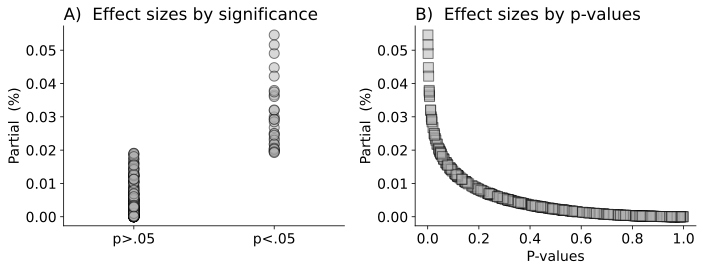

In [26]:
# plot
_,axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(pvals<.05,peta2,'ko',markersize=10,markerfacecolor=(.7,.7,.7),alpha=.5)
axs[0].set(xlim=[-.5,1.5],xticks=[0,1],xticklabels=['p>.05','p<.05'],ylabel=r'Partial  (%)')
axs[0].set_title(r'A)  Effect sizes by significance')

axs[1].plot(pvals,peta2,'ks',markersize=10,markerfacecolor=(.7,.7,.7),alpha=.5)
axs[1].set(xlabel='P-values',ylabel=r'Partial  (%)')
axs[1].set_title(r'B)  Effect sizes by p-values')

# display the figure
plt.tight_layout()
plt.show()

Now repeat for a random sample size

In [27]:
# experiment params
nTests = 300 # number of tests to simulate
groups = ['1']*N + ['2']*N
pvals = np.zeros(nTests)  # counter
peta2 = np.zeros(nTests)


In [28]:
# the experiment
for i in range(nTests):

  # sample size
  N = np.random.randint(10,10000)
  groups = ['1']*N + ['2']*N

  ##simulate the data
  data1 = np.random.normal(0,1,size=N)
  data2 = np.random.normal(np.random.rand()**2,1,size=N)
  data  = np.concatenate((data1,data2),axis=0)

  # run an ANOVA
  df = pd.DataFrame({'TheData':data,'Group':groups})
  anova = pg.anova(data=df,dv='TheData',between='Group')

  # count if significant
  pvals[i] = anova['p-unc'].item()
  peta2[i] = 100*anova['np2'].item()


In [29]:
# print the results
print(f'{np.sum(pvals<.05)} of {nTests} tests ({np.sum(pvals<.05)*100/nTests:.2f}%) had p<.05 with N={N}.')
     

242 of 300 tests (80.67%) had p<.05 with N=4721.


/tmp/ipykernel_18362/566303917.py:8: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(pvals),peta2,'ks',markersize=10,markerfacecolor=(.7,.7,.7),alpha=.5)


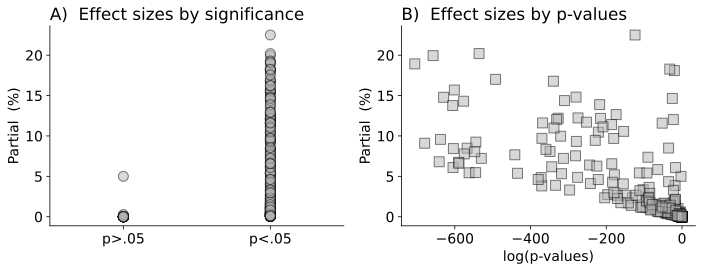

In [30]:
# plot
_,axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(pvals<.05,peta2,'ko',markersize=10,markerfacecolor=(.7,.7,.7),alpha=.5)
axs[0].set(xlim=[-.5,1.5],xticks=[0,1],xticklabels=['p>.05','p<.05'],ylabel=r'Partial  (%)')
axs[0].set_title(r'A)  Effect sizes by significance')

axs[1].plot(np.log(pvals),peta2,'ks',markersize=10,markerfacecolor=(.7,.7,.7),alpha=.5)
axs[1].set(xlabel='log(p-values)',ylabel=r'Partial  (%)')
axs[1].set_title(r'B)  Effect sizes by p-values')

# display the figure
plt.tight_layout()
plt.show()

# Exe 7

In [31]:
# create data
n_subjects = 30
n_conditions = 3
data = np.random.normal(size=(n_subjects,n_conditions))
data[:,1] += .25 # small offset to measurement #2
data[:,2] += .5  # small offset to measurement #3

# Create a DataFrame
df1 = pd.DataFrame(data, columns=['Cond1','Cond2','Cond3'])

# Convert to long format
df = pd.melt(df1.reset_index(), id_vars=['index'], value_vars=['Cond1','Cond2','Cond3'])
df.columns = ['Subject', 'Condition', 'Value']

In [32]:
# repeated-measures ANOVA
rmANOVA = pg.rm_anova(data=df, dv='Value', within='Condition', subject='Subject', detailed=True)
print('Results of a repeated-measures ANOVA:')
display(rmANOVA)


Results of a repeated-measures ANOVA:


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,Condition,11.900068,2,5.950034,4.834279,0.011434,0.112171,0.991113
1,Error,71.386437,58,1.230801,NaN,NaN,NaN,NaN


In [33]:
# between-subjects ANOVA
ANOVA = pg.anova(data=df,dv='Value', between='Condition',detailed=True)
print(f'\n\nResults of a between-subjects ANOVA')
display(ANOVA)



Results of a between-subjects ANOVA


,Source,SS,DF,MS,F,p-unc,np2
0,Condition,11.900068,2,5.950034,5.495918,0.005654,0.112171
1,Within,94.188631,87,1.082628,NaN,NaN,NaN


In [34]:
# the experiment
nReps = 200

# initialize a matrix of p-values
pvals = np.zeros((nReps,2))

# start the experiment
for i in range(nReps):

  data = np.random.normal(size=(n_subjects,n_conditions)) 
  data[:,1] += .25
  data[:,2] += .5

  # Create a DataFrame
  df1 = pd.DataFrame(data, columns=['Cond1','Cond2','Cond3'])
  df = pd.melt(df1.reset_index(), id_vars=['index'], value_vars=['Cond1','Cond2','Cond3'])
  df.columns = ['Subject', 'Condition', 'Value']

  # the two ANOVAs on the same data
  rmANOVA = pg.rm_anova(data=df, dv='Value', within='Condition', subject='Subject')
  ANOVA = pg.anova(data=df,dv='Value', between='Condition')

  # store the p-values
  pvals[i,0] = rmANOVA['p-unc'].item()
  pvals[i,1] = ANOVA['p-unc'].item()

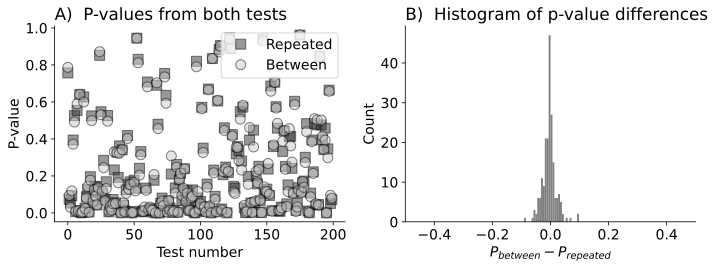

In [36]:
# plot
_,axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(np.arange(200),pvals[:,0],'ks',markersize=10,markerfacecolor=(.2,.2,.2),alpha=.5,label='Repeated')
axs[0].plot(np.arange(200),pvals[:,1],'ko',markersize=10,markerfacecolor=(.8,.8,.8),alpha=.5,label='Between')
axs[0].set(xlabel='Test number',ylabel='P-value')
axs[0].set_title(r'A)  P-values from both tests')
axs[0].legend()

axs[1].hist(np.diff(pvals,axis=1),bins='fd',color=(.5,.5,.5))
axs[1].set_title(r'B)  Histogram of p-value differences')
axs[1].set(xlabel=r'$P_{between}-P_{repeated}$',ylabel='Count')
axs[1].set(xlim=[-.5,.5])

# display the figure
plt.tight_layout()
plt.show()